# Quality Metrics for the Spectral Matching of light shources $f_{\mathrm{sd}}$

# Attention: Using a small change in luxpy. For the original version use LED_B3 instead of LED_L41 for the caculations.

In [1]:
# Use some packages
import luxpy as lx
from luxpy.utils import todim
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from sklearn.linear_model import LinearRegression
from empir19nrm02 import _RES, _SPD
from empir19nrm02.f1prime import py_f1PrimeG, py_f1PrimeGlx, py_fsdG
from empir19nrm02.tools import plotSelectedSPD, plotYxy, plotHist, plotCorrMatrixSmall, plotHistScales
from sigfig import round

In [2]:
strfsd = '$f_{\mathrm{sd}}$'
strL41 = '$S_{\mathrm{L41}}$'
strillA = '$S_{\mathrm{A}}$'
strillL = strL41
strvonLambda = '$(\lambda)$'
strVLambda = '$V(\lambda)$'

#strAU = ' / A.U.'
strAU = ''

a1=1
a2=0.7
a3=0.4
a4=0.3

In [3]:

selected_detector = 73
selected_SPD = 142
fig_number = 1
fig_type= '.svg'
table_type= '.csv'
label_font_size=14

def get_fig_file_name(filename=None, table=False):
    global fig_number
    global fig_type
    if filename is None:
        file_name = r'fsd\Fig' + str(fig_number) + fig_type
        fig_number+=1
    else:
        if table:
            file_name = r'fsd\Table' + filename + table_type
        else:
            file_name = r'fsd\Fig' + filename + fig_type
    return file_name

def save_fig(filename=None):
    return pyplot.savefig( get_fig_file_name(filename), bbox_inches='tight', pad_inches=0)

## Read some detector and spd data from the empir19nrm02 package
<li>every entry (spectral responsivity, SPD is a row in the matrix, the first row is containing the wavelength scale)</li>
<li>For all data files in this project the first (sometimes also the second) data set(s) are used for referecne
calculations (e.g. for detectors the first one is V(Lambda) and for SPDs the first is standard illuminant A
and the second one sometimes illuminant L41)</li>

### Select the source data for simulation (change the entries in res_data (True/False for the required data sets)
### Detector Data
<li>VLDetectors: Current Collection</li>
<li>CIES025_VLDetectors: Collection from CIES025:2015</li>

In [4]:
res_data = { 'VLDetectors': False,
             'CIES025_VLDetectors': False,
             'TC2_90_VLDetectors': True
              }
detector_start_reading = True
detector_names = ''
print('Detector data base:')
for detector, enable in res_data.items():
    print('Name:', detector )
    print('    Size:', _RES[detector]['S']['data'].shape[0]-1 )
    print('    Use:', enable )
    if enable:
        detector_names = detector_names + detector + ' '
        if detector_start_reading:
            vldetectorsTemp=_RES[detector]['S']['data'].copy()
            wl_start = vldetectorsTemp[0].copy()
            detector_start_reading=False
        else:
            data_to_append = _RES[detector]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='linear')
            vldetectorsTemp = np.vstack( (vldetectorsTemp, interpolated_data[1:]))

print( 'Detectors for the Simulation:')
print( '    Detectors:', detector_names)
print( '    Number of detectors:', vldetectorsTemp.shape[0]-1)

Detector data base:
Name: VLDetectors
    Size: 127
    Use: False
Name: CIES025_VLDetectors
    Size: 121
    Use: False
Name: TC2_90_VLDetectors
    Size: 78
    Use: True
Detectors for the Simulation:
    Detectors: TC2_90_VLDetectors 
    Number of detectors: 78


## Test the data analyses for different wavelength resolutions based on the same data set.
<li>bInterpol=False means using the original wavelength resolution of the data set (probably 5nm)</li>
<li>bInterpol=True  means using the wavelength resolution of 1nm by interpolation of the original data to that resolution</li>

In [5]:
bInterpol = True
if bInterpol:
    wl_interpol = lx.getwlr([360,830,1])
    vldetectors=lx.cie_interp(vldetectorsTemp, wl_interpol, negative_values_allowed=True, kind='S')
else:
    vldetectors=vldetectorsTemp

print( vldetectorsTemp.shape)
print( vldetectors.shape)

(79, 401)
(79, 471)


### Select the SPD data for simulation (change the entries in spd_data (True/False for the required data sets)
### SPD Data
<li>BB: Collection of Blackbody SPDs </li>
<li>PTLED':  Collection of PT White LEDs</li>
<li>CIES025_PTLED':  Collection of PT White LEDs used in CIES025:2015</li>
<li>OSRAM_PTLED':  Collection of PT White LEDs from OSRAM</li>
<li>RGBLED':  Collection of RGB White LEDs</li>
<li>CIES025_RGBLED':  Collection of RGB White LEDs used in CIES025:2015</li>
<li>PHOTOLED':  Collection of PT White LEDs from the PhotoLED-Project</li>
<li>MONOLED':  Collection of Monochrome LEDs</li>
<li>OSRAM_MONOLED':  Collection of Monochrome LEDs from OSRAM</li>

In [6]:
spd_data = {'BB': False,
            'PTLED': False,
            'CIES025_PTLED': True,
            'OSRAM_PTLED': False,
            'RGBLED':  False,
            'CIES025_RGBLED':  False,
            'PHOTOLED':  False,
            'TC2_90':  False,
            'MONOLED':  False,
            'OSRAM_MONOLED':  False}


spd_start_reading = True
spd_names = ''
print('SPD data base:')
for spd, enable in spd_data.items():
    print('Name:', spd, '\t\t\t', 'Size:', _SPD[spd]['S']['data'].shape[0]-1, '\t\t', 'Use:', enable)
    if enable:
        spd_names = spd_names + spd + ' '
        if spd_start_reading:
            spectraTemp=_SPD[spd]['S']['data'].copy()
            wl_start = spectraTemp[0].copy()
            spd_start_reading=False
        else:
            data_to_append = _SPD[spd]['S']['data'].copy()
            interpolated_data = lx.cie_interp(data_to_append, wl_start, negative_values_allowed=True, kind='S')
            spectraTemp = np.vstack( (spectraTemp, interpolated_data))

print( '\nSPDs for the Simulation:')
print( '    SPD:', spd_names)
print( '    Number of spds:', spectraTemp.shape[0]-1)

SPD data base:
Name: BB 			 Size: 55 		 Use: False
Name: PTLED 			 Size: 229 		 Use: False
Name: CIES025_PTLED 			 Size: 228 		 Use: True
Name: OSRAM_PTLED 			 Size: 137 		 Use: False
Name: RGBLED 			 Size: 98 		 Use: False
Name: CIES025_RGBLED 			 Size: 97 		 Use: False
Name: PHOTOLED 			 Size: 1496 		 Use: False
Name: TC2_90 			 Size: 1300 		 Use: False
Name: MONOLED 			 Size: 288 		 Use: False
Name: OSRAM_MONOLED 			 Size: 260 		 Use: False

SPDs for the Simulation:
    SPD: CIES025_PTLED 
    Number of spds: 228


In [7]:
if bInterpol:
    spectra=lx.cie_interp(spectraTemp, wl_interpol, negative_values_allowed=True, kind='S')
else:
    spectra=spectraTemp

print( spectraTemp.shape)
print( spectra.shape)

(229, 81)
(229, 471)


### Exporting the interpolated data

In [8]:
np.savetxt(r'fsd\fsd_spectra.csv', spectra.T, delimiter=';')
np.savetxt(r'fsd\fsd_detector.csv', vldetectors.T, delimiter=';')

### Calculating all the different $f_{sd}$ values.

# What is the topic here?

In [9]:
def norm_sd( spectratmp):
    _norm_sd = spectratmp/np.trapz(spectratmp*vldetectors[1], vldetectors[0])
    return _norm_sd

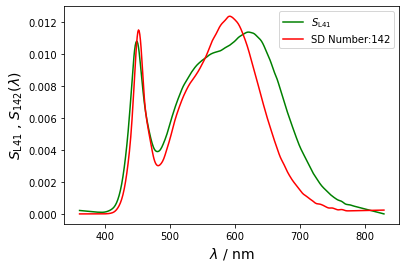

In [10]:
fig0, ax0 = pyplot.subplots()
strNumber = str(selected_SPD)
ax0.plot(spectra[0], norm_sd(spectra[2]),'g-', label=strL41)
ax0.plot(spectra[0], norm_sd(spectra[selected_SPD]),'r-', label=r'SD Number:' + strNumber)
ax0.legend()
pyplot.ylabel(strL41 + r' , $S_{' + strNumber + '}(\lambda)' + strAU+ '$',fontsize=label_font_size)
pyplot.xlabel('$\lambda$ / nm',fontsize=label_font_size)
save_fig(filename='SampleSD')

In [11]:
def label_management( locfig0, locax2nd, strColor2nd='blue'):
    lines_labels = [ax.get_legend_handles_labels() for ax in locfig0.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    locax2nd.spines['right'].set_color(strColor2nd)
    locax2nd.yaxis.label.set_color(strColor2nd)
    locax2nd.tick_params(axis='y', colors=strColor2nd)
    return [lines, labels]


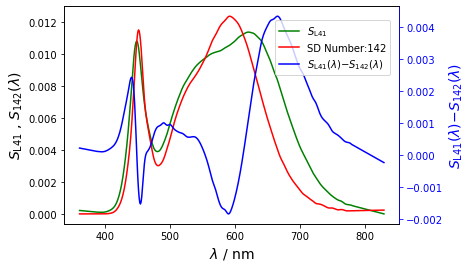

In [12]:
strNumberSD = str(selected_SPD)

fig0, ax0 = pyplot.subplots()
strNumber = str(selected_SPD)
ax0.plot(spectra[0], norm_sd( spectra[2]),'g-', label=strL41)
ax0.plot(spectra[0], norm_sd( spectra[selected_SPD]),'r-', label=r'SD Number:' + strNumber)
ax0.set_ylabel(strL41 + r' , $S_{' + strNumberSD + '}(\lambda)'+ strAU +'$',fontsize=label_font_size)
ax0.set_xlabel('$\lambda$ / nm',fontsize=label_font_size)


strDiff = strL41 + '$(\lambda)$' + '$-S_{' + strNumberSD + '}(\lambda)$'
ax1 = ax0.twinx()
ax1.plot(spectra[0], norm_sd(spectra[2])-norm_sd(spectra[selected_SPD]), 'b', label=strDiff)
ax1.set_ylabel( strDiff,fontsize=label_font_size)


[lines, labels]=label_management( fig0, ax1, 'blue')
fig0.legend(lines, labels, bbox_to_anchor=(0.6, 0.55, 0.4, 0.3), loc='upper left')


save_fig(filename='SampleDSAbsDiff')


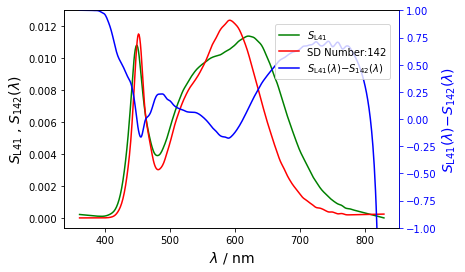

In [13]:
fig0, ax0 = pyplot.subplots()
strNumber = str(selected_SPD)
ax0.plot(spectra[0], norm_sd(spectra[2]),'g-', label=strL41)
ax0.plot(spectra[0], norm_sd(spectra[selected_SPD]),'r-', label=r'SD Number:' + strNumber)
ax0.set_ylabel(strL41 + r' , $S_{' + strNumberSD + '}(\lambda)'+ strAU +'$',fontsize=label_font_size)
ax0.set_xlabel('$\lambda$ / nm',fontsize=label_font_size)


strDiff = strL41 + strvonLambda + '$-S_{' + strNumberSD + '}$' + strvonLambda
ax1 = ax0.twinx()
ax1.plot(spectra[0], (norm_sd(spectra[2])-norm_sd(spectra[selected_SPD]))/norm_sd(spectra[2]), 'b', label=strDiff)
ax1.set_ylabel( strDiff,fontsize=label_font_size)
ax1.set_ylim([-1,1])

[lines, labels]=label_management( fig0, ax1, 'blue')
fig0.legend(lines, labels, bbox_to_anchor=(0.6, 0.55, 0.4, 0.3), loc='upper left')


save_fig(filename='SampleDSRelDiff')

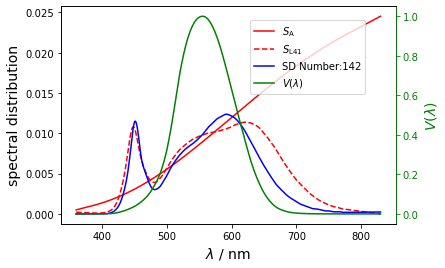

In [14]:
fig0, ax0 = pyplot.subplots()
ax0.plot(spectra[0], norm_sd(spectra[1]),'r-', label=strillA)
ax0.plot(spectra[0], norm_sd(spectra[2]),'r--', label=strillL)
ax0.plot(spectra[0], norm_sd(spectra[selected_SPD]),'b-', label=r'SD Number:' + strNumberSD)
ax0.set_xlabel('$\lambda$ / nm',fontsize=label_font_size)
ax0.set_ylabel('spectral distribution',fontsize=label_font_size)

ax1 = ax0.twinx()
ax1.plot(vldetectors[0], vldetectors[1],'g-', label=strVLambda)
ax1.set_ylabel( strVLambda,fontsize=label_font_size)

[lines, labels] = label_management(fig0, ax1, 'green')
fig0.legend(lines, labels, bbox_to_anchor=(0.55, 0.55, 0.4, 0.3), loc='upper left')

save_fig(filename='SampleSelectedSDs')

### Let's calculate fsd from all spectra
### Use LED_B3 instead of LED_L41 for the original luxpy version, please.

0.05830544037487591


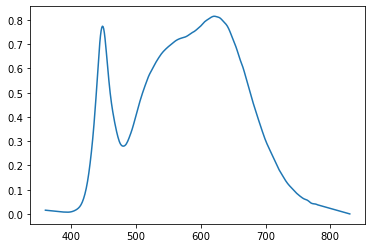

In [15]:
test_number = 2
pyplot.plot(spectra[0], spectra[test_number])
fsd_test=py_fsdG( spectra[0], spectra[test_number], strObserver='1931_2', iObserverOffset = 1, strTarget='LED_L41')
print( fsd_test)

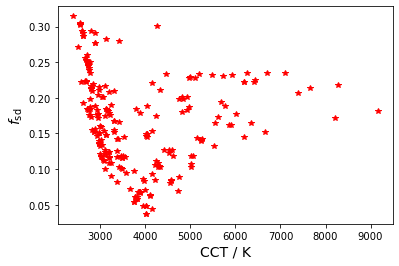

In [16]:
fsd=py_fsdG( spectra[0], spectra[1:], strObserver='1931_2', iObserverOffset = 1, strTarget='LED_L41')
np.savetxt(r'fsd\fsd_result.csv', fsd, delimiter=';')

#spectraP = np.vstack((spectra[0], spectra[1110], spectra[1111]))
#np.savetxt(r'fsd\cct_rpoblem_spectra.csv', spectraP.T, delimiter=';')


#for i in range(1,spectra.shape[0]):
#    #if i not in [1110, 1111]:
#        #pyplot.plot(spectra[0],spectra[i], 'r*')
#        spectraTmp = np.vstack((spectra[0], spectra[i]))
#        spectra_cct = lx.xyz_to_cct(lx.spd_to_xyz( spectraTmp))
#        print( i, spectra_cct)
spectra_cct = lx.xyz_to_cct(lx.spd_to_xyz( spectra))
idx = np.where(np.abs(spectra_cct[:,0]) < 10000)
pyplot.plot(spectra_cct[idx],fsd[idx], 'r*')
pyplot.xlabel( 'CCT / K',fontsize=label_font_size)
pyplot.ylabel( strfsd,fontsize=label_font_size)
save_fig(filename='fsd_CCT')

In [17]:
#pyplot.plot(spectra_cct[idx],fsd[idx], 'r*')
#pyplot.xlim([3000,5000])
#pyplot.ylim([0,0.5])
#pyplot.xlabel( 'CCT / K',fontsize=label_font_size)
#pyplot.ylabel( strfsd,fontsize=label_font_size)
#save_fig(filename='fsd_CCT_scale')

In [18]:
f1pA=lx.spectral_mismatch_and_uncertainty.f1prime(vldetectors, S_C='A', cieobs='1931_2', s_target_index=2)
np.savetxt(r'fsd\fsd_f1pA.csv', f1pA, delimiter=';')
b_SMCFLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( spectra, vldetectors, S_C='LED_L41')
np.savetxt(r'fsd\fsd_SMCF.csv', np.abs(1-b_SMCFLED).T, delimiter=';')

idx4Star = np.where(f1pA<0.015)
idx3Star = np.where((f1pA>=0.015) & (f1pA<0.03))
idx2Star = np.where((f1pA>=0.03) & (f1pA<0.06))
idx1Star = np.where((f1pA>=0.06))

In [19]:
diag_x_min = 0
diag_x_max = 0.2
diag_y_min = 0
diag_y_max = 0.02
diag_y_max_slope = 0.2

In [20]:
def calc_slope( staruse, starName):
    n_spectra = spectra.shape[0]-1
    n_curr_detector = len(staruse[0])
    org = np.abs(1-b_SMCFLED[:,staruse])
    org = np.reshape(org, (n_spectra, n_curr_detector))
    help = np.divide(org.T, fsd).T
    q_data = np.quantile(help, 0.95, axis=1)
    print( starName, np.quantile(help, 0.95))
    return [help, q_data]

print( 'Quantile data (95%) for the different photometer classes:')
[data4Star, qdata4Star]=calc_slope( idx4Star, '4Star')
[data3Star, qdata3Star]=calc_slope( idx3Star, '3Star')
[data2Star, qdata2Star]=calc_slope( idx2Star, '2Star')
[data1Star, qdata1Star]=calc_slope( idx1Star, '1Star')

Quantile data (95%) for the different photometer classes:
4Star 0.017084804995858384
3Star 0.035050423089124726
2Star 0.060649487754324244
1Star 0.12169358650273683


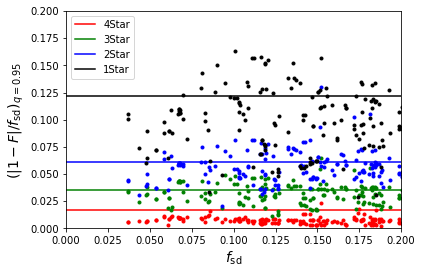

In [21]:
fig0, ax0 = pyplot.subplots()
ax0.plot(fsd, qdata4Star,'r.')
ax0.axhline( np.quantile(data4Star, 0.95), color='r', label='4Star')
ax0.plot(fsd, qdata3Star,'g.')
ax0.axhline( np.quantile(data3Star, 0.95), color='g', label='3Star')
ax0.plot(fsd, qdata2Star,'b.')
ax0.axhline( np.quantile(data2Star, 0.95), color='b', label='2Star')
ax0.plot(fsd, qdata1Star,'k.')
ax0.axhline( np.quantile(data1Star, 0.95), color='k', label='1Star')
ax0.set_xlim([diag_x_min,diag_x_max])
ax0.set_ylim([diag_y_min,diag_y_max_slope])
pyplot.xlabel( strfsd,fontsize=label_font_size)
pyplot.ylabel( '$(|1-F|/f_{\mathrm{sd}})_{q=0.95}$',fontsize=label_font_size)
pyplot.legend()
save_fig(filename='F_fsd_slope')

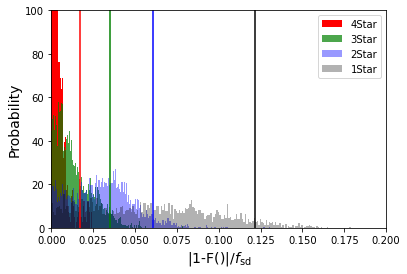

In [22]:
hBins = 200
fig, ax1 = pyplot.subplots()
ax1.set_xlim([diag_y_min,diag_y_max_slope])
ax1.set_ylim([0,100])
ax1.set_xlabel('|1-F()|/'+strfsd, fontsize=label_font_size)
ax1.set_ylabel('Probability', fontsize=label_font_size)
ax1.hist(data4Star.flatten(),  bins=hBins, alpha = a1, log=False, density=True, label='4Star', color = 'r')
ax1.axvline( np.quantile(data4Star, 0.95), color='r')
ax1.hist(data3Star.flatten(),  bins=hBins, alpha = a2, log=False, density=True, label='3Star', color = 'g')
ax1.axvline( np.quantile(data3Star, 0.95), color='g')
ax1.hist(data2Star.flatten(),  bins=hBins, alpha = a3, log=False, density=True, label='2Star', color = 'b')
ax1.axvline( np.quantile(data2Star, 0.95), color='b')
ax1.hist(data1Star.flatten(), bins=hBins, alpha = a4, log=False, density=True, label='1Star', color = 'k')
ax1.axvline( np.quantile(data1Star, 0.95), color='k')
ax1.legend()
save_fig(filename='Hist_fsd_AllStars')


In [23]:
def fsd_regression( reg_data, ax, str_color):
    sort_index = np.argsort(fsd)
    fsd_sort=fsd[sort_index]
    x_pred = fsd_sort.reshape(-1,1)
    x = fsd.reshape(-1,1)
    lr_model = LinearRegression()
    lr_model.fit(x, reg_data)
    y_pred_mean = lr_model.predict(x_pred)
    m_mean=lr_model.coef_[0]
    m_mean_r_sq = lr_model.score(x, reg_data)
    print( m_mean, m_mean_r_sq)
    ax.plot(x_pred,  y_pred_mean, str_color)
    return m_mean

def plot_star( staruse, starName, loglog=False):

    shape1=b_SMCFLED.shape[0]
    shape2=len(staruse[0])

    fig0, ax0 = pyplot.subplots()
    smcfSelect = np.abs(1-b_SMCFLED[:,staruse])
    smcfSelect=np.reshape(smcfSelect, (shape1, shape2))
    meanData = np.mean(smcfSelect, axis=1)
    medianData = np.quantile(smcfSelect, 0.5, axis=1)
    q95Data=np.quantile(smcfSelect, 0.95, axis=1)
    ax0.plot(fsd, meanData,'r*',label=r'$\bar{F}_{i}^{a}$')
    ax0.plot(fsd, medianData,'g*', label=r'$F^{a}_{i,q=0.50}$')
    ax0.plot(fsd, q95Data,'b*', label=r'$F^{a}_{i,q=0.95}$')
    if loglog:
        pyplot.xlim([0.01,1.00])
        pyplot.ylim([0.0001,0.1])
        pyplot.loglog()
    else:
        pyplot.xlim([diag_x_min,diag_x_max])
        pyplot.ylim([diag_y_min,diag_y_max])

    pyplot.legend()
    pyplot.grid(True,which="both",ls="--")
    pyplot.xlabel( strfsd,fontsize=label_font_size)
    pyplot.ylabel( '$F_{x}(S(\lambda))$',fontsize=label_font_size)
    pyplot.title( 'Photometer selection:' + starName)
    save_fig(filename='F_fsd_Part'+starName + str(loglog))
    print( starName, 'with ', shape2, ' Detectors in the Class')
    print('meanData')
    mMean = fsd_regression( meanData, ax0, 'r--')
    print('medianData')
    mMedian = fsd_regression( medianData, ax0, 'g--')
    print('q95Data')
    mq95 = fsd_regression( q95Data, ax0, 'b--')
    return [meanData, mMean, medianData, mMedian, q95Data, mq95]


4Star with  12  Detectors in the Class
meanData
0.009294282323920228 0.36811610262308825
medianData
0.011750598815682254 0.32715456941653265
q95Data
0.014878712834958924 0.4079958561924947
3Star with  31  Detectors in the Class
meanData
0.012178522200085388 0.5973653850063056
medianData
0.00993865808531017 0.5383809565848914
q95Data
0.02517890576467856 0.5961531256776661
2Star with  23  Detectors in the Class
meanData
0.026032099614884043 0.7028643236108376
medianData
0.02701328723740424 0.6401946890185574
q95Data
0.04666362536804159 0.6993084324391469
1Star with  12  Detectors in the Class
meanData
0.042820065290826194 0.4525396985326534
medianData
0.050194187542173446 0.47293780785974404
q95Data
0.07293635289709724 0.5369613963078785


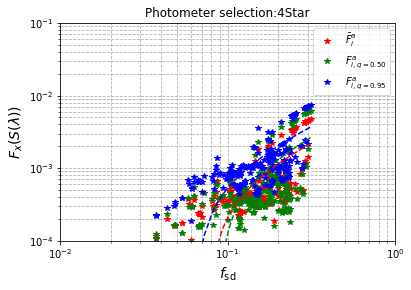

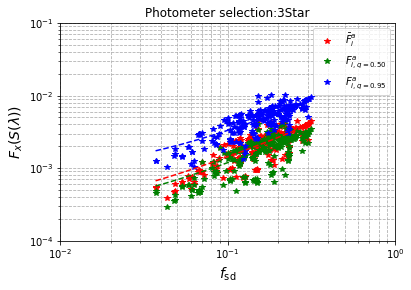

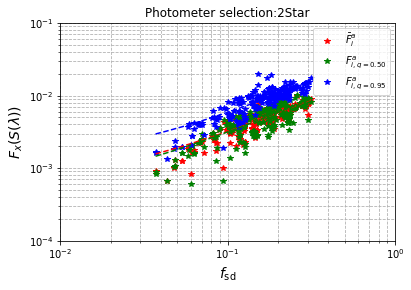

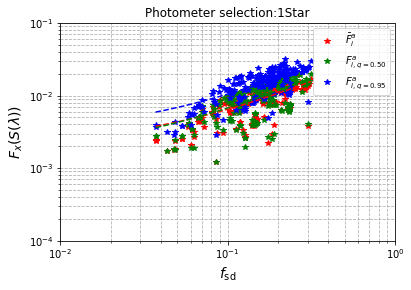

In [24]:
use_loglog = True
[meanData4, mMean4, medianData4, mMedian4, q95Data4, mq954] = plot_star( idx4Star, '4Star', loglog=use_loglog)
[meanData3, mMean3, medianData3, mMedian3, q95Data3, mq953] = plot_star( idx3Star, '3Star', loglog=use_loglog)
[meanData2, mMean2, medianData2, mMedian2, q95Data2, mq952] = plot_star( idx2Star, '2Star', loglog=use_loglog)
[meanData1, mMean1, medianData1, mMedian1, q95Data1, mq951] = plot_star( idx1Star, '1Star', loglog=use_loglog)


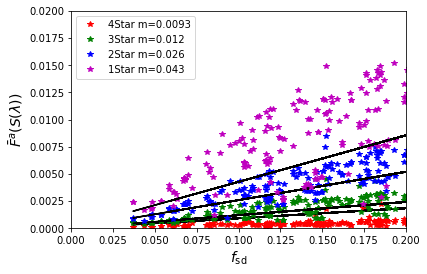

In [25]:
fig0, ax0 = pyplot.subplots()

ax0.plot(fsd, meanData4,'r*',label=r'4Star m='+ round( str(mMean4), sigfigs=2))
ax0.plot(fsd, mMean4*fsd, 'k-')
ax0.plot(fsd, meanData3,'g*',label=r'3Star m='+ round( str(mMean3), sigfigs=2))
ax0.plot(fsd, mMean3*fsd, 'k-')
ax0.plot(fsd, meanData2,'b*',label=r'2Star m='+ round( str(mMean2), sigfigs=2))
ax0.plot(fsd, mMean2*fsd, 'k-')
ax0.plot(fsd, meanData1,'m*',label=r'1Star m='+ round( str(mMean1), sigfigs=2))
ax0.plot(fsd, mMean1*fsd, 'k-')
pyplot.xlim([diag_x_min,diag_x_max])
pyplot.ylim([diag_y_min,diag_y_max])
pyplot.xlabel(strfsd,fontsize=label_font_size)
pyplot.ylabel(r'$\barF^{a}(S(\lambda))$',fontsize=label_font_size)
pyplot.legend()
save_fig(filename='F_fsd_meanData')

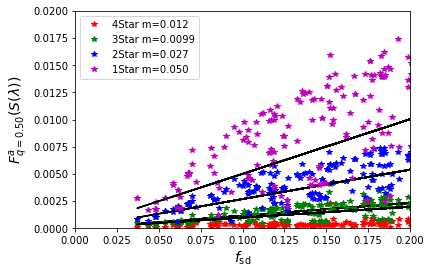

In [26]:
fig0, ax0 = pyplot.subplots()

ax0.plot(fsd, medianData4,'r*',label=r'4Star m='+ round( str(mMedian4), sigfigs=2))
ax0.plot(fsd, mMedian4*fsd, 'k-')
ax0.plot(fsd, medianData3,'g*',label=r'3Star m='+ round( str(mMedian3), sigfigs=2))
ax0.plot(fsd, mMedian3*fsd, 'k-')
ax0.plot(fsd, medianData2,'b*',label=r'2Star m='+ round( str(mMedian2), sigfigs=2))
ax0.plot(fsd, mMedian2*fsd, 'k-')
ax0.plot(fsd, medianData1,'m*',label=r'1Star m='+ round( str(mMedian1), sigfigs=2))
ax0.plot(fsd, mMedian1*fsd, 'k-')
pyplot.xlim([diag_x_min,diag_x_max])
pyplot.ylim([diag_y_min,diag_y_max])
pyplot.xlabel(strfsd,fontsize=label_font_size)
pyplot.ylabel(r'$F^{a}_{q=0.50}(S(\lambda))$',fontsize=label_font_size)
pyplot.legend()
save_fig(filename='F_fsd_medianData')

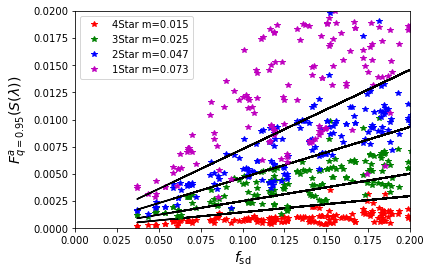

In [27]:
fig0, ax0 = pyplot.subplots()

ax0.plot(fsd, q95Data4,'r*',label=r'4Star m='+ round( str(mq954), sigfigs=2))
ax0.plot(fsd, mq954*fsd, 'k-')
ax0.plot(fsd, q95Data3,'g*',label=r'3Star m='+ round( str(mq953), sigfigs=2))
ax0.plot(fsd, mq953*fsd, 'k-')
ax0.plot(fsd, q95Data2,'b*',label=r'2Star m='+ round( str(mq952), sigfigs=2))
ax0.plot(fsd, mq952*fsd, 'k-')
ax0.plot(fsd, q95Data1,'m*',label=r'1Star m='+ round( str(mq951), sigfigs=2))
ax0.plot(fsd, mq951*fsd, 'k-')
pyplot.xlim([diag_x_min,diag_x_max])
pyplot.ylim([diag_y_min,diag_y_max])
pyplot.xlabel(strfsd,fontsize=label_font_size)
pyplot.ylabel(r'$F^{a}_{q=0.95}(S(\lambda))$',fontsize=label_font_size)
pyplot.legend()
save_fig(filename='F_fsd_q95Data')



# Ende Gelände